<a href="https://colab.research.google.com/github/Keskinksn/Bert-Model-Fake-News-Detection/blob/main/Lymphography_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *This lymphography domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. (Restricted access)*

**Dataset Characteristics:** Multivariate

**Subject Area:** Health and Medicine

**Associated Tasks:** Classification

**Feature Type:** Categorical


###**Features**

1. **lymphatics:** normal, arched, deformed, displaced
2. **block of affere:** no, yes
3. **bl. of lymph. c:** no, yes
4. **bl. of lymph. s:** no, yes
5. **by pass:** no, yes
6. **extravasates:** no, yes
7. **regeneration of:** no, yes
8. **early uptake in:** no, yes
9. **lym.nodes dimin:** 0-3
10. **lym.nodes enlar:** 1-4
11. **changes in lym.:*** bean, oval, round
12. **defect in node:** no, lacunar, lac. marginal, lac. central
13. **changes in node:** no, lacunar, lac. margin, lac. central
14. **changes in stru:** no, grainy, drop-like, coarse, diluted, reticular, stripped, faint,
15. **special forms:** no, chalices, vesicles
16. **dislocation of:** no, yes
17. **exclusion of no:** no, yes
18. **no. of nodes in:** 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, >=70

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import joblib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import classification_report, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMClassifier
import warnings
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
df = pd.read_csv('/content/lymphography.csv', header=None)
df.columns = attributes = [
    "class",
    "lymphatics",
    "block of affere",
    "bl. of lymph. c",
    "bl. of lymph. s",
    "by pass",
    "extravasates",
    "regeneration of",
    "early uptake in",
    "lym.nodes dimin",
    "lym.nodes enlar",
    "changes in lym.",
    "defect in node",
    "changes in node",
    "changes in stru",
    "special forms",
    "dislocation of",
    "exclusion of no",
    "no. of nodes in"
]
df.head()

,class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym.,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
0,3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
1,2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
2,3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
4,2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=15):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=15)

def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    dataframe[col_name] = np.where(dataframe[col_name] < low_limit, low_limit, dataframe[col_name])
    dataframe[col_name] = np.where(dataframe[col_name] > up_limit, up_limit, dataframe[col_name])



def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


   class      Ratio
2     81  54.729730
3     61  41.216216
4      4   2.702703
1      2   1.351351
--------------------------------------------------------------------------------


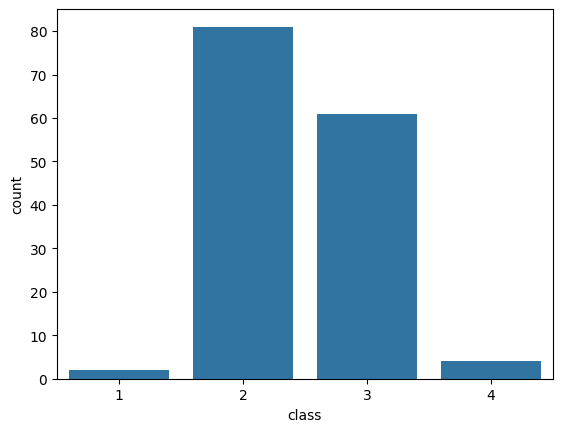

   lymphatics      Ratio
2          67  45.270270
3          46  31.081081
4          33  22.297297
1           2   1.351351
--------------------------------------------------------------------------------


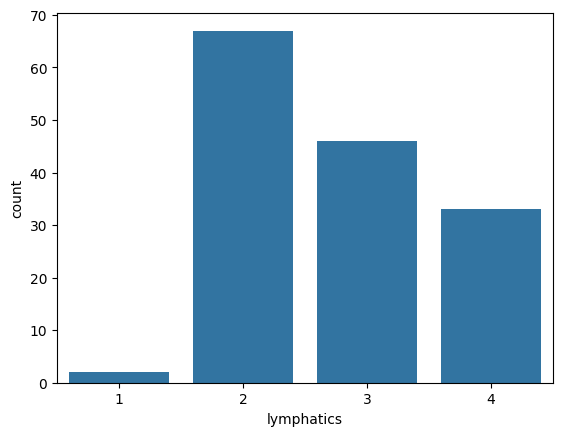

   block of affere      Ratio
2               82  55.405405
1               66  44.594595
--------------------------------------------------------------------------------


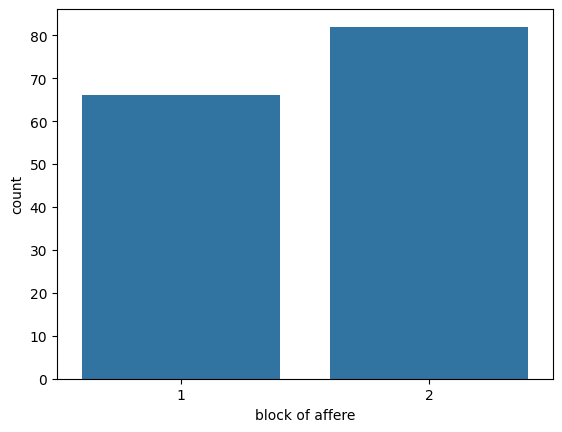

   bl. of lymph. c      Ratio
1              122  82.432432
2               26  17.567568
--------------------------------------------------------------------------------


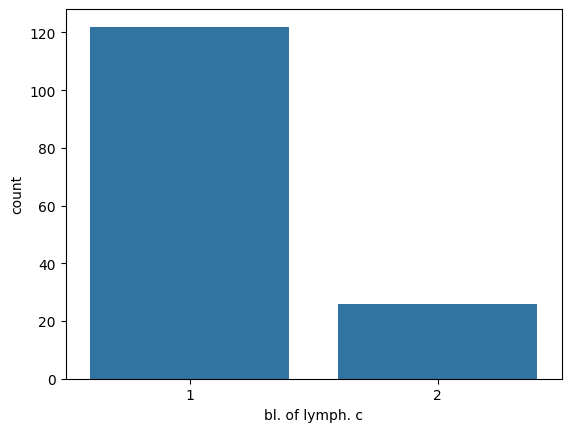

   bl. of lymph. s     Ratio
1              141  95.27027
2                7   4.72973
--------------------------------------------------------------------------------


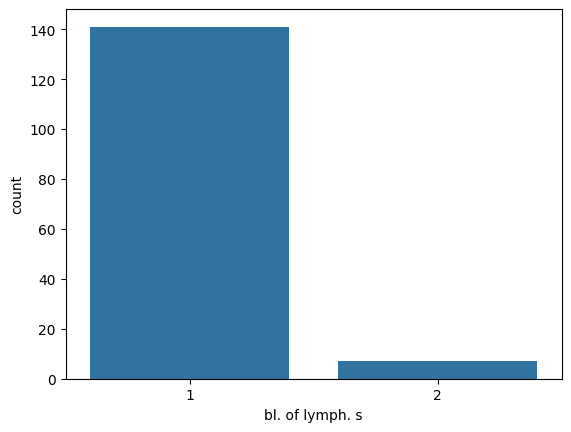

   by pass      Ratio
1      112  75.675676
2       36  24.324324
--------------------------------------------------------------------------------


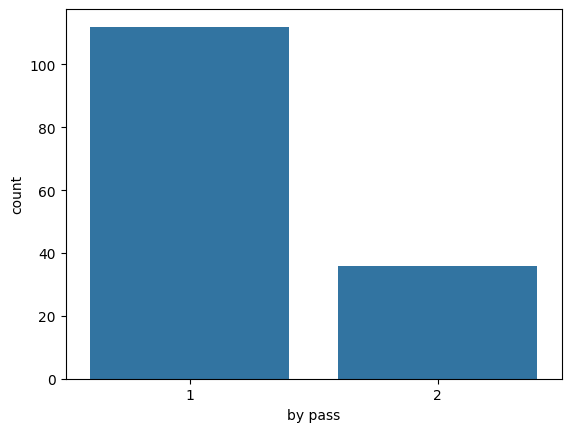

   extravasates      Ratio
2            75  50.675676
1            73  49.324324
--------------------------------------------------------------------------------


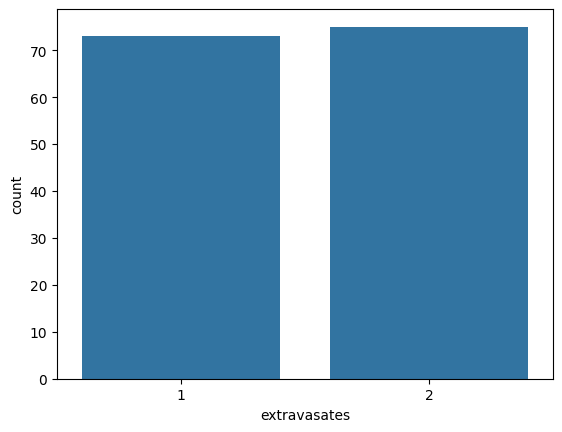

   regeneration of      Ratio
1              138  93.243243
2               10   6.756757
--------------------------------------------------------------------------------


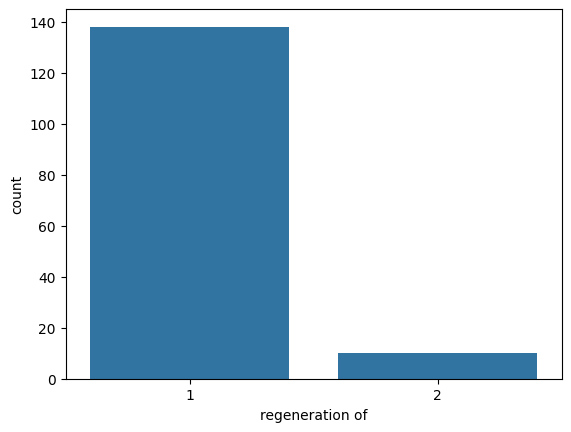

   early uptake in     Ratio
2              104  70.27027
1               44  29.72973
--------------------------------------------------------------------------------


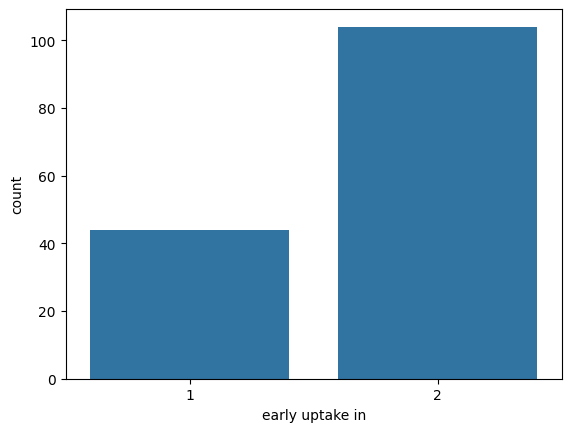

   lym.nodes dimin      Ratio
1              142  95.945946
3                3   2.027027
2                3   2.027027
--------------------------------------------------------------------------------


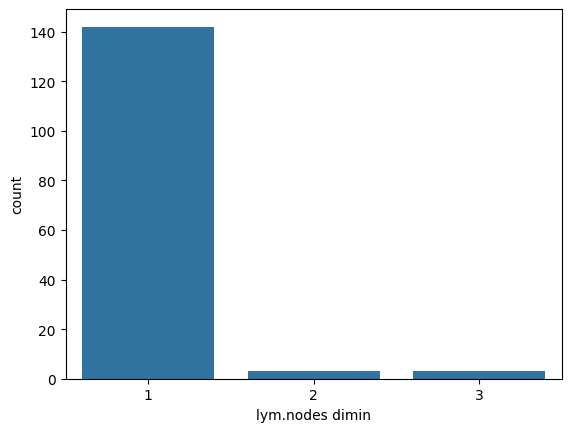

   lym.nodes enlar      Ratio
2               72  48.648649
3               43  29.054054
4               20  13.513514
1               13   8.783784
--------------------------------------------------------------------------------


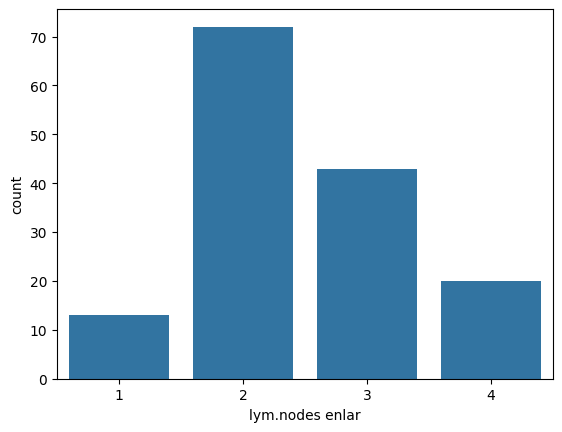

   changes in lym.      Ratio
2               77  52.027027
3               65  43.918919
1                6   4.054054
--------------------------------------------------------------------------------


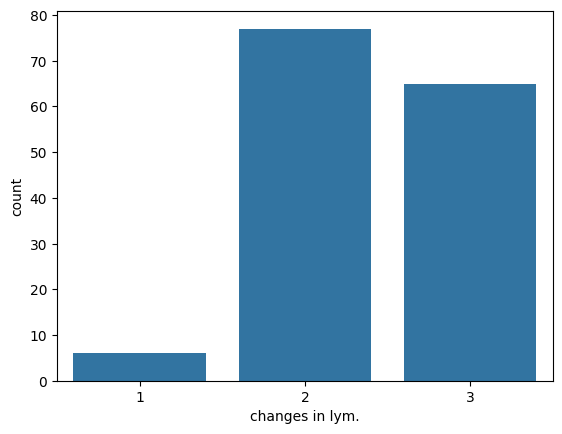

   defect in node      Ratio
4              50  33.783784
2              49  33.108108
3              46  31.081081
1               3   2.027027
--------------------------------------------------------------------------------


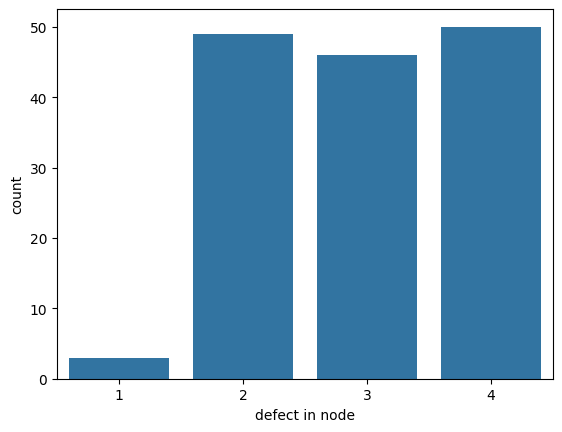

   changes in node      Ratio
3               75  50.675676
2               42  28.378378
4               25  16.891892
1                6   4.054054
--------------------------------------------------------------------------------


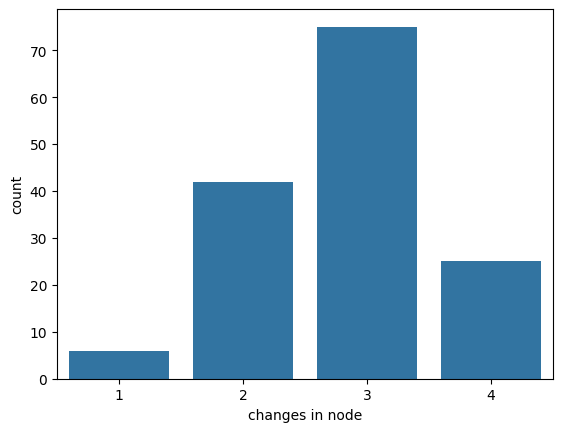

   changes in stru      Ratio
8               45  30.405405
4               31  20.945946
5               28  18.918919
3               19  12.837838
2               14   9.459459
7                7   4.729730
6                2   1.351351
1                2   1.351351
--------------------------------------------------------------------------------


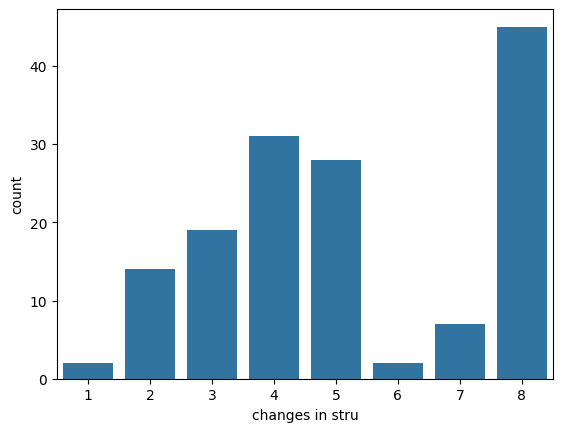

   special forms      Ratio
3             77  52.027027
2             43  29.054054
1             28  18.918919
--------------------------------------------------------------------------------


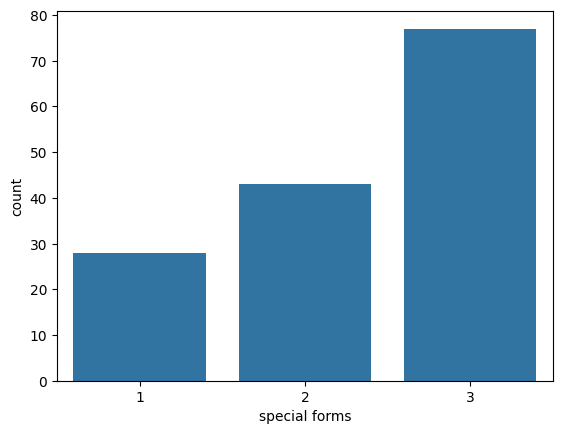

   dislocation of      Ratio
2              98  66.216216
1              50  33.783784
--------------------------------------------------------------------------------


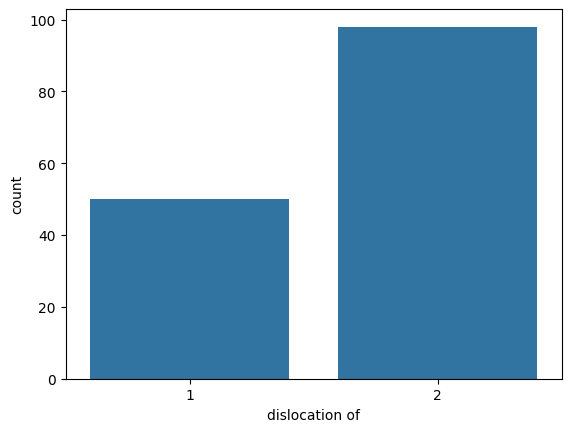

   exclusion of no      Ratio
2              117  79.054054
1               31  20.945946
--------------------------------------------------------------------------------


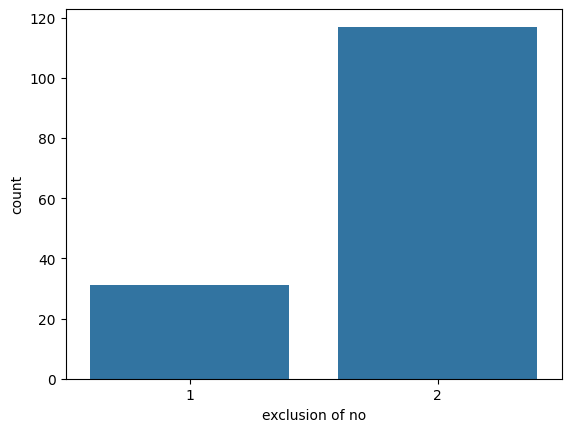

   no. of nodes in      Ratio
1               57  38.513514
2               37  25.000000
3               18  12.162162
4               10   6.756757
7                8   5.405405
6                8   5.405405
5                8   5.405405
8                2   1.351351
--------------------------------------------------------------------------------


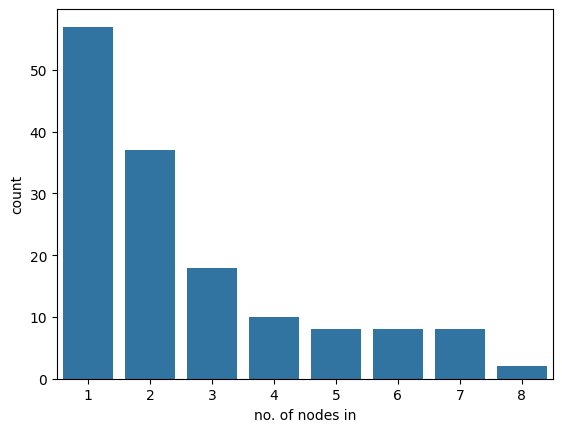

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("--------------------------------------------------------------------------------")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col)


In [10]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
  target_summary_with_cat(df, "class", col)

       TARGET_MEAN
class             
1              1.0
2              2.0
3              3.0
4              4.0


            TARGET_MEAN
lymphatics             
1              1.000000
2              2.417910
3              2.521739
4              2.515152


                 TARGET_MEAN
block of affere             
1                   2.681818
2                   2.268293


                 TARGET_MEAN
bl. of lymph. c             
1                   2.467213
2                   2.384615


                 TARGET_MEAN
bl. of lymph. s             
1                   2.425532
2                   3.000000


         TARGET_MEAN
by pass             
1             2.4375
2             2.5000


              TARGET_MEAN
extravasates             
1                2.383562
2                2.520000


                 TARGET_MEAN
regeneration of             
1                   2.391304
2                   3.300000


                 TARGET_MEAN
early uptake in             
1               

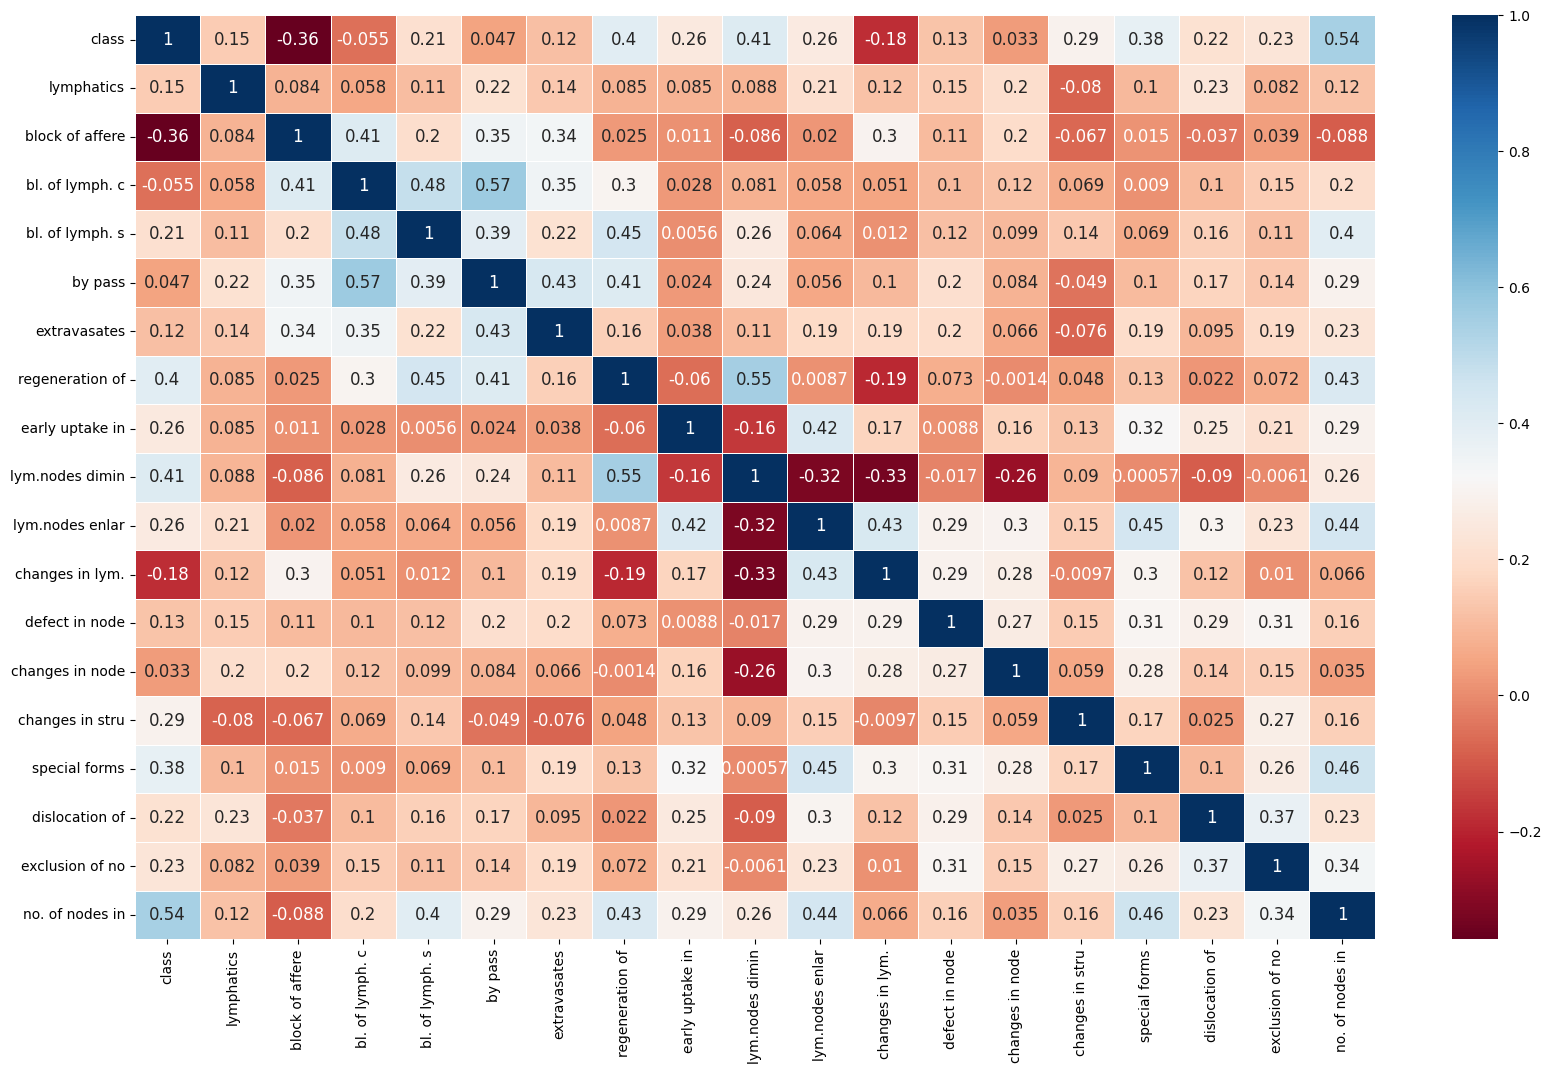

In [11]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

correlation_matrix(df, cat_cols)


In [12]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

In [13]:
cat_cols = [col for col in cat_cols if "class" not in col]

df = one_hot_encoder(df, cat_cols, drop_first=True)

for col in num_cols:
    print(col, check_outlier(df, col, 0.01, 0.99))

y = df["class"]
X = df.drop(["class"], axis=1)

In [26]:
def base_models(X, y, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"], multi_class='ovr'):
    print("Base Models...")
    classifiers = [
        ('Logistic Regression', LogisticRegression()),
        ("Decision Tree", DecisionTreeClassifier()),
        ("Random Forest", RandomForestClassifier()),
        ('GBM', GradientBoostingClassifier()),
        ('LightGBM', LGBMClassifier(verbose=-1, force_col_wise=True)),
        ('AdaBoost Classifier', AdaBoostClassifier()),
        ('CatBoost Classifier', CatBoostClassifier(logging_level='Silent')),
        ('Multilayer Perceptron', MLPClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('SVM', SVC()),
        ('Deep Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
        ('Extra Trees Classifier', ExtraTreesClassifier()),
        ('AdaBoost Classifier', AdaBoostClassifier()),
        ('SGD Classifier', SGDClassifier()),
        ('Gaussian Process Classifier', GaussianProcessClassifier())]

    for name, classifier in classifiers:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"\n ------- {name}" " -------")
        for metric in scoring:
            print(f"{metric}: {round(cv_results['test_' + metric].mean(), 4)}")

classifier = base_models(X, y)


Base Models...

 ------- Logistic Regression -------
accuracy: 0.831
precision_macro: 0.6491
recall_macro: 0.6495
f1_macro: 0.6463

 ------- Decision Tree -------
accuracy: 0.7703
precision_macro: 0.5172
recall_macro: 0.5441
f1_macro: 0.5248

 ------- Random Forest -------
accuracy: 0.8108
precision_macro: 0.5719
recall_macro: 0.5742
f1_macro: 0.5671

 ------- GBM -------
accuracy: 0.7834
precision_macro: 0.6409
recall_macro: 0.6425
f1_macro: 0.6401

 ------- LightGBM -------
accuracy: 0.7766
precision_macro: 0.5463
recall_macro: 0.5534
f1_macro: 0.5449

 ------- AdaBoost Classifier -------
accuracy: 0.6221
precision_macro: 0.6095
recall_macro: 0.5997
f1_macro: 0.5782

 ------- CatBoost Classifier -------
accuracy: 0.8175
precision_macro: 0.635
recall_macro: 0.6428
f1_macro: 0.637

 ------- Multilayer Perceptron -------
accuracy: 0.831
precision_macro: 0.7115
recall_macro: 0.7123
f1_macro: 0.7101

 ------- KNN -------
accuracy: 0.7297
precision_macro: 0.4611
recall_macro: 0.4737
f1_mac

In [61]:
# Multilayer Perceptron
mlp_params = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,), (200,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.05, 0.1],  #
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}

dnn_params = {
    'hidden_layer_sizes': [(100,), (200,), (300,), (400,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# SGD Classifier
sgd_params = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive', 'constant', 'optimal']
}

# CatBoost Classifier
cat_params = {
    'iterations': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.15, 0.2],
    'depth': [4, 6, 8]
}

In [62]:
classifiers = [
        ('CatBoost Classifier', CatBoostClassifier(), cat_params),
        ('Multilayer Perceptron', MLPClassifier(), mlp_params),
        ('Deep Neural Network', MLPClassifier(), dnn_params),
        ('SGD Classifier', SGDClassifier(), sgd_params)]

In [63]:
from sklearn.model_selection import cross_validate, GridSearchCV
import warnings

def hyperparameter_optimization(X, y, cv=10, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"], multi_class='ovr'):
    print("Hyperparameter Optimization Loading....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring, return_train_score=True)
        for metric in scoring:
            print(f" {metric} (Before): {round(cv_results['test_' + metric].mean(), 4)}")

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)

        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring, return_train_score=True)
        for metric in scoring:
            test_score_before = round(cv_results['test_' + metric].mean(), 4)
            print(f"Test {metric} (After): {test_score_before}")

        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models


In [64]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization Loading....
########## CatBoost Classifier ##########
Learning rate set to 0.07139
0:	learn: 1.3202379	total: 8.07ms	remaining: 8.06s
1:	learn: 1.2525661	total: 10.1ms	remaining: 5.05s
2:	learn: 1.2024933	total: 16.2ms	remaining: 5.39s
3:	learn: 1.1605019	total: 23.7ms	remaining: 5.91s
4:	learn: 1.1290208	total: 32.9ms	remaining: 6.55s
5:	learn: 1.0949596	total: 41.8ms	remaining: 6.93s
6:	learn: 1.0444464	total: 45.8ms	remaining: 6.5s
7:	learn: 1.0079728	total: 53.7ms	remaining: 6.66s
8:	learn: 0.9778116	total: 63.2ms	remaining: 6.96s
9:	learn: 0.9565385	total: 73.9ms	remaining: 7.31s
10:	learn: 0.9375088	total: 85.1ms	remaining: 7.65s
11:	learn: 0.9035702	total: 96.6ms	remaining: 7.96s
12:	learn: 0.8823556	total: 108ms	remaining: 8.21s
13:	learn: 0.8577643	total: 122ms	remaining: 8.58s
14:	learn: 0.8343794	total: 131ms	remaining: 8.57s
15:	learn: 0.8137513	total: 142ms	remaining: 8.74s
16:	learn: 0.7920646	total: 154ms	remaining: 8.88s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


17:	learn: 0.7738621	total: 171ms	remaining: 9.35s
18:	learn: 0.7511748	total: 176ms	remaining: 9.08s
19:	learn: 0.7314751	total: 180ms	remaining: 8.84s
20:	learn: 0.7163781	total: 191ms	remaining: 8.92s
21:	learn: 0.7007101	total: 204ms	remaining: 9.08s
22:	learn: 0.6827852	total: 216ms	remaining: 9.17s
23:	learn: 0.6719877	total: 226ms	remaining: 9.2s
24:	learn: 0.6569693	total: 237ms	remaining: 9.23s
25:	learn: 0.6402805	total: 248ms	remaining: 9.28s
26:	learn: 0.6267157	total: 260ms	remaining: 9.38s
27:	learn: 0.6158766	total: 272ms	remaining: 9.43s
28:	learn: 0.6039987	total: 282ms	remaining: 9.44s
29:	learn: 0.5942398	total: 293ms	remaining: 9.46s
30:	learn: 0.5811012	total: 302ms	remaining: 9.45s
31:	learn: 0.5701458	total: 309ms	remaining: 9.34s
32:	learn: 0.5611219	total: 320ms	remaining: 9.37s
33:	learn: 0.5520761	total: 332ms	remaining: 9.43s
34:	learn: 0.5407229	total: 341ms	remaining: 9.39s
35:	learn: 0.5293059	total: 346ms	remaining: 9.27s
36:	learn: 0.5207083	total: 352m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12:	learn: 0.8790367	total: 76.3ms	remaining: 5.79s
13:	learn: 0.8496306	total: 86ms	remaining: 6.05s
14:	learn: 0.8237532	total: 94.5ms	remaining: 6.2s
15:	learn: 0.8025698	total: 99.9ms	remaining: 6.15s
16:	learn: 0.7875007	total: 106ms	remaining: 6.13s
17:	learn: 0.7684631	total: 112ms	remaining: 6.09s
18:	learn: 0.7476015	total: 115ms	remaining: 5.94s
19:	learn: 0.7321768	total: 121ms	remaining: 5.92s
20:	learn: 0.7083473	total: 129ms	remaining: 6s
21:	learn: 0.6956422	total: 135ms	remaining: 6s
22:	learn: 0.6839648	total: 141ms	remaining: 5.97s
23:	learn: 0.6701602	total: 146ms	remaining: 5.95s
24:	learn: 0.6520557	total: 152ms	remaining: 5.93s
25:	learn: 0.6387882	total: 159ms	remaining: 5.94s
26:	learn: 0.6265576	total: 169ms	remaining: 6.09s
27:	learn: 0.6168188	total: 177ms	remaining: 6.16s
28:	learn: 0.6025337	total: 183ms	remaining: 6.13s
29:	learn: 0.5884263	total: 189ms	remaining: 6.11s
30:	learn: 0.5776017	total: 195ms	remaining: 6.09s
31:	learn: 0.5682716	total: 201ms	re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20:	learn: 0.6897850	total: 125ms	remaining: 5.82s
21:	learn: 0.6733865	total: 134ms	remaining: 5.96s
22:	learn: 0.6594592	total: 141ms	remaining: 6s
23:	learn: 0.6429435	total: 147ms	remaining: 5.97s
24:	learn: 0.6287088	total: 153ms	remaining: 5.95s
25:	learn: 0.6161109	total: 158ms	remaining: 5.92s
26:	learn: 0.6014711	total: 164ms	remaining: 5.91s
27:	learn: 0.5910111	total: 173ms	remaining: 6.01s
28:	learn: 0.5787521	total: 180ms	remaining: 6.03s
29:	learn: 0.5685341	total: 187ms	remaining: 6.03s
30:	learn: 0.5570020	total: 192ms	remaining: 6.01s
31:	learn: 0.5443148	total: 198ms	remaining: 5.98s
32:	learn: 0.5323643	total: 205ms	remaining: 6.01s
33:	learn: 0.5218086	total: 211ms	remaining: 5.99s
34:	learn: 0.5111854	total: 216ms	remaining: 5.97s
35:	learn: 0.5026048	total: 222ms	remaining: 5.94s
36:	learn: 0.4937884	total: 228ms	remaining: 5.94s
37:	learn: 0.4854950	total: 234ms	remaining: 5.92s
38:	learn: 0.4762119	total: 240ms	remaining: 5.92s
39:	learn: 0.4686393	total: 246ms	

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7:	learn: 1.0115226	total: 43ms	remaining: 5.33s
8:	learn: 0.9831207	total: 56.9ms	remaining: 6.27s
9:	learn: 0.9613089	total: 62.5ms	remaining: 6.19s
10:	learn: 0.9338331	total: 68ms	remaining: 6.12s
11:	learn: 0.9132647	total: 74.1ms	remaining: 6.1s
12:	learn: 0.8821246	total: 79.8ms	remaining: 6.06s
13:	learn: 0.8618295	total: 85.5ms	remaining: 6.02s
14:	learn: 0.8382020	total: 92ms	remaining: 6.04s
15:	learn: 0.8064023	total: 95.2ms	remaining: 5.85s
16:	learn: 0.7797450	total: 101ms	remaining: 5.85s
17:	learn: 0.7647101	total: 107ms	remaining: 5.85s
18:	learn: 0.7435279	total: 109ms	remaining: 5.63s
19:	learn: 0.7281636	total: 115ms	remaining: 5.63s
20:	learn: 0.7124200	total: 122ms	remaining: 5.68s
21:	learn: 0.6931098	total: 127ms	remaining: 5.66s
22:	learn: 0.6741532	total: 133ms	remaining: 5.64s
23:	learn: 0.6623722	total: 141ms	remaining: 5.75s
24:	learn: 0.6523143	total: 148ms	remaining: 5.78s
25:	learn: 0.6397872	total: 154ms	remaining: 5.77s
26:	learn: 0.6230787	total: 161m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20:	learn: 0.7192837	total: 116ms	remaining: 5.41s
21:	learn: 0.7004387	total: 125ms	remaining: 5.57s
22:	learn: 0.6814089	total: 133ms	remaining: 5.64s
23:	learn: 0.6718376	total: 139ms	remaining: 5.65s
24:	learn: 0.6582052	total: 145ms	remaining: 5.66s
25:	learn: 0.6433682	total: 148ms	remaining: 5.56s
26:	learn: 0.6259322	total: 154ms	remaining: 5.56s
27:	learn: 0.6144014	total: 160ms	remaining: 5.56s
28:	learn: 0.6033349	total: 166ms	remaining: 5.57s
29:	learn: 0.5941036	total: 175ms	remaining: 5.65s
30:	learn: 0.5836782	total: 186ms	remaining: 5.81s
31:	learn: 0.5751269	total: 193ms	remaining: 5.85s
32:	learn: 0.5648904	total: 200ms	remaining: 5.85s
33:	learn: 0.5532199	total: 205ms	remaining: 5.83s
34:	learn: 0.5430200	total: 211ms	remaining: 5.83s
35:	learn: 0.5327352	total: 217ms	remaining: 5.82s
36:	learn: 0.5226137	total: 223ms	remaining: 5.81s
37:	learn: 0.5148737	total: 229ms	remaining: 5.8s
38:	learn: 0.5056817	total: 235ms	remaining: 5.8s
39:	learn: 0.4988013	total: 241ms

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 1.1888932	total: 1.74ms	remaining: 172ms
1:	learn: 1.0586909	total: 5.03ms	remaining: 247ms
2:	learn: 0.9670429	total: 7.17ms	remaining: 232ms
3:	learn: 0.8725922	total: 10.8ms	remaining: 258ms
4:	learn: 0.8182231	total: 13.4ms	remaining: 255ms
5:	learn: 0.7550021	total: 17ms	remaining: 266ms
6:	learn: 0.7075273	total: 19.9ms	remaining: 265ms
7:	learn: 0.6641665	total: 22.4ms	remaining: 258ms
8:	learn: 0.6312286	total: 25ms	remaining: 252ms
9:	learn: 0.5961094	total: 27.2ms	remaining: 245ms
10:	learn: 0.5630310	total: 29.5ms	remaining: 238ms
11:	learn: 0.5382210	total: 31.8ms	remaining: 233ms
12:	learn: 0.5144659	total: 35.5ms	remaining: 238ms
13:	learn: 0.4971243	total: 41.3ms	remaining: 254ms
14:	learn: 0.4835106	total: 43.7ms	remaining: 247ms
15:	learn: 0.4619904	total: 45.9ms	remaining: 241ms
16:	learn: 0.4455876	total: 47.3ms	remaining: 231ms
17:	learn: 0.4345895	total: 50ms	remaining: 228ms
18:	learn: 0.4172819	total: 52.7ms	remaining: 225ms
19:	learn: 0.4050898	total: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28:	learn: 0.3180968	total: 58.7ms	remaining: 144ms
29:	learn: 0.3107827	total: 61.1ms	remaining: 143ms
30:	learn: 0.3070958	total: 63ms	remaining: 140ms
31:	learn: 0.3007512	total: 65ms	remaining: 138ms
32:	learn: 0.2931717	total: 67ms	remaining: 136ms
33:	learn: 0.2865097	total: 68.5ms	remaining: 133ms
34:	learn: 0.2816612	total: 70.1ms	remaining: 130ms
35:	learn: 0.2746692	total: 71.5ms	remaining: 127ms
36:	learn: 0.2683991	total: 73.3ms	remaining: 125ms
37:	learn: 0.2615098	total: 75.2ms	remaining: 123ms
38:	learn: 0.2569460	total: 77.1ms	remaining: 121ms
39:	learn: 0.2507301	total: 79.6ms	remaining: 119ms
40:	learn: 0.2469024	total: 81ms	remaining: 117ms
41:	learn: 0.2413620	total: 82.8ms	remaining: 114ms
42:	learn: 0.2355804	total: 84.6ms	remaining: 112ms
43:	learn: 0.2331439	total: 86.4ms	remaining: 110ms
44:	learn: 0.2298303	total: 88.3ms	remaining: 108ms
45:	learn: 0.2224843	total: 90.1ms	remaining: 106ms
46:	learn: 0.2182616	total: 92.1ms	remaining: 104ms
47:	learn: 0.2152199

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0:	learn: 1.2182074	total: 5.65ms	remaining: 559ms
1:	learn: 1.0924464	total: 8.64ms	remaining: 423ms
2:	learn: 0.9552568	total: 10.9ms	remaining: 353ms
3:	learn: 0.8488622	total: 13ms	remaining: 311ms
4:	learn: 0.7716105	total: 15.1ms	remaining: 286ms
5:	learn: 0.7165016	total: 17ms	remaining: 266ms
6:	learn: 0.6615578	total: 18.8ms	remaining: 250ms
7:	learn: 0.6310813	total: 20.7ms	remaining: 238ms
8:	learn: 0.5905896	total: 22.5ms	remaining: 228ms
9:	learn: 0.5579404	total: 24.3ms	remaining: 219ms
10:	learn: 0.5297120	total: 26.2ms	remaining: 212ms
11:	learn: 0.5089015	total: 28ms	remaining: 205ms
12:	learn: 0.4837957	total: 29.9ms	remaining: 200ms
13:	learn: 0.4616525	total: 31.7ms	remaining: 194ms
14:	learn: 0.4407507	total: 33.5ms	remaining: 190ms
15:	learn: 0.4257347	total: 37.5ms	remaining: 197ms
16:	learn: 0.4096427	total: 39.4ms	remaining: 192ms
17:	learn: 0.3987408	total: 41.2ms	remaining: 188ms
18:	learn: 0.3865549	total: 43ms	remaining: 183ms
19:	learn: 0.3787792	total: 44

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


55:	learn: 0.2063248	total: 101ms	remaining: 79.4ms
56:	learn: 0.2033546	total: 104ms	remaining: 78.6ms
57:	learn: 0.1999224	total: 107ms	remaining: 77.4ms
58:	learn: 0.1941224	total: 110ms	remaining: 76.4ms
59:	learn: 0.1918530	total: 112ms	remaining: 74.8ms
60:	learn: 0.1891345	total: 115ms	remaining: 73.2ms
61:	learn: 0.1867715	total: 117ms	remaining: 71.5ms
62:	learn: 0.1838315	total: 119ms	remaining: 69.7ms
63:	learn: 0.1821130	total: 120ms	remaining: 67.7ms
64:	learn: 0.1789661	total: 124ms	remaining: 66.8ms
65:	learn: 0.1773329	total: 128ms	remaining: 65.8ms
66:	learn: 0.1727447	total: 130ms	remaining: 64ms
67:	learn: 0.1693155	total: 132ms	remaining: 62.2ms
68:	learn: 0.1677498	total: 134ms	remaining: 60.2ms
69:	learn: 0.1658773	total: 136ms	remaining: 58.2ms
70:	learn: 0.1635214	total: 138ms	remaining: 56.2ms
71:	learn: 0.1613969	total: 140ms	remaining: 54.3ms
72:	learn: 0.1598852	total: 141ms	remaining: 52.3ms
73:	learn: 0.1573445	total: 143ms	remaining: 50.4ms
74:	learn: 0.1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21:	learn: 0.3920127	total: 44.7ms	remaining: 158ms
22:	learn: 0.3865505	total: 48.2ms	remaining: 161ms
23:	learn: 0.3767026	total: 50.6ms	remaining: 160ms
24:	learn: 0.3677284	total: 53.4ms	remaining: 160ms
25:	learn: 0.3611195	total: 55.6ms	remaining: 158ms
26:	learn: 0.3554102	total: 57.7ms	remaining: 156ms
27:	learn: 0.3490299	total: 59.6ms	remaining: 153ms
28:	learn: 0.3454901	total: 61.4ms	remaining: 150ms
29:	learn: 0.3392773	total: 63.2ms	remaining: 148ms
30:	learn: 0.3308135	total: 65ms	remaining: 145ms
31:	learn: 0.3235928	total: 66.8ms	remaining: 142ms
32:	learn: 0.3166281	total: 68.6ms	remaining: 139ms
33:	learn: 0.3093413	total: 70.3ms	remaining: 137ms
34:	learn: 0.3053885	total: 72.1ms	remaining: 134ms
35:	learn: 0.3006114	total: 73.8ms	remaining: 131ms
36:	learn: 0.2920785	total: 75.7ms	remaining: 129ms
37:	learn: 0.2840488	total: 77.6ms	remaining: 127ms
38:	learn: 0.2774483	total: 79.5ms	remaining: 124ms
39:	learn: 0.2696589	total: 81.3ms	remaining: 122ms
40:	learn: 0.2

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochas

 accuracy (Before): 0.8505
 precision_macro (Before): 0.7482
 recall_macro (Before): 0.7554
 f1_macro (Before): 0.7495


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Test accuracy (After): 0.8581
Test precision_macro (After): 0.7875
Test recall_macro (After): 0.7913
Test f1_macro (After): 0.7866
Multilayer Perceptron best params: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}

########## Deep Neural Network ##########


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill

 accuracy (Before): 0.831
 precision_macro (Before): 0.7333
 recall_macro (Before): 0.7406
 f1_macro (Before): 0.7343


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.

Test accuracy (After): 0.8381
Test precision_macro (After): 0.7399
Test recall_macro (After): 0.7468
Test f1_macro (After): 0.7402
Deep Neural Network best params: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}

########## SGD Classifier ##########


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 accuracy (Before): 0.8171
 precision_macro (Before): 0.6938
 recall_macro (Before): 0.7037
 f1_macro (Before): 0.6965


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Test accuracy (After): 0.831
Test precision_macro (After): 0.7272
Test recall_macro (After): 0.7427
Test f1_macro (After): 0.7276
SGD Classifier best params: {'alpha': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'elasticnet'}



In [80]:
import warnings

for name, model in best_models.items():
    print(f"########## {name} ##########")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"], return_train_score=True)
    for metric in ["accuracy", "precision_macro", "recall_macro", "f1_macro"]:
        test_score = round(cv_results['test_' + metric].mean(), 4)
        print(f"{metric}: Test Score - {test_score}")
    print()


########## CatBoost Classifier ##########
0:	learn: 1.1888932	total: 1.63ms	remaining: 161ms
1:	learn: 1.0586909	total: 3.51ms	remaining: 172ms
2:	learn: 0.9670429	total: 5.68ms	remaining: 184ms
3:	learn: 0.8725922	total: 7.26ms	remaining: 174ms
4:	learn: 0.8182231	total: 9.26ms	remaining: 176ms
5:	learn: 0.7550021	total: 12.9ms	remaining: 203ms
6:	learn: 0.7075273	total: 14.5ms	remaining: 193ms
7:	learn: 0.6641665	total: 16.1ms	remaining: 185ms
8:	learn: 0.6312286	total: 18.6ms	remaining: 188ms
9:	learn: 0.5961094	total: 21ms	remaining: 189ms
10:	learn: 0.5630310	total: 23ms	remaining: 186ms
11:	learn: 0.5382210	total: 24.6ms	remaining: 180ms
12:	learn: 0.5144659	total: 29.5ms	remaining: 198ms
13:	learn: 0.4971243	total: 31.7ms	remaining: 195ms
14:	learn: 0.4835106	total: 33.9ms	remaining: 192ms
15:	learn: 0.4619904	total: 36.3ms	remaining: 190ms
16:	learn: 0.4455876	total: 38.3ms	remaining: 187ms
17:	learn: 0.4345895	total: 40ms	remaining: 182ms
18:	learn: 0.4172819	total: 41.5ms	rem

**Model Performance Achieved with Hyperparameter Optimization**

########## CatBoost Classifier ##########
* accuracy: Test Score - 0.8443
* precision_macro: Test Score - 0.7458
* recall_macro: Test Score - 0.7512
* f1_macro: Test Score - 0.7444

########## Multilayer Perceptron ##########
* accuracy: Test Score - 0.8648
* precision_macro: Test Score - 0.7929
* recall_macro: Test Score - 0.7954
* f1_macro: Test Score - 0.7911

########## Deep Neural Network ##########
* accuracy: Test Score - 0.8448
* precision_macro: Test Score - 0.7783
* recall_macro: Test Score - 0.7802
* f1_macro: Test Score - 0.7754

########## SGD Classifier ##########
* accuracy: Test Score - 0.8452
* precision_macro: Test Score - 0.7844
* recall_macro: Test Score - 0.7822
* f1_macro: Test Score - 0.779

**Stacking & Ensemble Learning**

In [108]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(
        estimators=[
            ('SGD Classifier', best_models["SGD Classifier"]),
            ('Multilayer Perceptron', best_models["Multilayer Perceptron"])
        ],
        voting='hard'
    ).fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=15, scoring=["accuracy"])
    # print(f"test_accuracy: {cv_results['test_accuracy'].mean():.4f}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=15.
  warnings.warn(


In [109]:
print(f"test_accuracy: {cv_results['test_accuracy'].mean():.4f}")

test_accuracy: 0.8452


In [99]:
voting_clf

VotingClassifier(estimators=[('SGD Classifier',
                              SGDClassifier(alpha=0.01, penalty='elasticnet')),
                             ('Multilayer Perceptron',
                              MLPClassifier(activation='tanh', alpha=0.1,
                                            learning_rate='adaptive',
                                            solver='lbfgs'))])

**Prediction for a New Observation**

In [102]:
X.columns
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

joblib.dump(voting_clf, "Lymphography.pkl")

new_model = joblib.load("Lymphography.pkl")
new_model.predict(random_user)

array([2])

**CLASS**
1. normal find,
2. metastases,
3. malign lymph,
4. fibrosis